# Multi-Class N-Pair Loss

In [1]:
from pathlib import Path

METRICS_FILEPATH = "metrics.json"

MODEL_DIR = "models"
FIG_DIR = "figures"

# Create output directories if not exist
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

## Intuition

When One-Shot classifying, the model will have to compare the query sample against a single positive and multitude of negatives.
[Multi-Class N-Pair Loss](https://lilianweng.github.io/posts/2021-05-31-contrastive/#n-pair-loss) mimics this scenario.

We'll reserve the in-depth technical explanation for the report and just try to get some intuition for the loss function:

- The model will be structured as a Siamese Neural Network
- For every batch, we input $N$ positive pairs into the models (each corresponding to a different class)
- Both branches of the Siamese Network will therefore output $N$ embeddings per batch

Assume we formed $N=3$ pairs and our model outputs 4D embeddings. We could form two embedding matrices such that each row represents a sample's embedding:

$$
E_1 =
\begin{pmatrix}
5 & 1 & 1 & 14 \\
1 & 7 & 10 & 0 \\
15 & 8 & 1 & 3
\end{pmatrix}
$$

$$
E_2 =
\begin{pmatrix}
4 & 0 & 1 & 17 \\
0 & 6 & 11 & 0 \\
13 & 10 & 0 & 2
\end{pmatrix}
$$

(Notice the similarity between the same rows (= the same samples) across the matrices and the dissimilarity across the rows of a single matrix (= different samples).)

We can transpose one of the embedding matrices and multiply it with the other:

$$
\begin{pmatrix}
5 & 1 & 1 & 14 \\
1 & 7 & 10 & 0 \\
15 & 8 & 1 & 3
\end{pmatrix}

\cdot

\begin{pmatrix}
4 & 0 & 13 \\
0 & 6 & 10 \\
1 & 11 & 0 \\
17 & 0 & 2
\end{pmatrix}

=

\begin{pmatrix}
259 & 17 & 103 \\
14 & 152 & 83 \\
112 & 59 & 281
\end{pmatrix}
$$


$\rightarrow$ We calculated a similarity matrix between all the embeddings in the batch.

Every $\text{cell}_{i, j}$ represents the similarity between the embedding in $\text{row}_i$ of $E_1$ and $\text{row}_j$ of $E_2$.

If we computed the `argmax` for each row, we would end up with a one-hot categorical matrix for the batch:

$$
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
$$

We could now use Categorical Crossentropy as the loss function.

## One-Shot Classification using Multi-Class N-Pair Loss

For our experiment we'll choose $N=19$, meaning every batch will contain exactly one matching pair for every class in the training set.

To accomplish this, we'll use a custom [Keras data generator](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence):

In [2]:
import random
import numpy as np
import numpy.typing as npt
from keras.utils import Sequence
from sklearn.utils import shuffle

class NPairDataGen(Sequence):
    """Custom data generator.
    
    Reference:
        https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
    """

    x: npt.NDArray[np.float32]
    y: npt.NDArray[np.int_]
    unique_labels: npt.NDArray[np.int_]
    num_classes: int
    num_samples_per_class: int
    
    def __init__(
        self,
        x: npt.NDArray[np.float32],
        y_numeric: npt.NDArray[np.int_]
    ):
        self.x = x.copy()
        self.y = y_numeric.copy()

        # Sort samples by label (in case they were shuffled)
        sort_idx = np.argsort(self.y)
        self.x = self.x[sort_idx]
        self.y = self.y[sort_idx]

        # Determine the class with the least amount of samples
        self.unique_labels, counts = np.unique(self.y, return_counts=True)
        self.num_classes = len(self.unique_labels)
        min_count = np.min(counts)

        # Reduce label count for each class to min amount of samples
        reduced_y = np.repeat(self.unique_labels, min_count)
        
        # Pick the data according to the reduced labels
        reduced_x: list[npt.NDArray[np.float32]] = []
        for label in self.unique_labels:
            indices = np.where(self.y == label)[0][:min_count]
            reduced_x.extend(list(self.x[indices]))

        self.y = reduced_y
        self.x = np.array(reduced_x)
        self.num_samples_per_class = min_count

    def on_epoch_end(self):
        pass

    def __get_random_matching_index(self, y: int, Y: npt.NDArray[np.int_]) -> int:
        matching_indices = np.where(Y == y)[0]
        matching_idx = random.choice(matching_indices)
        assert Y[matching_idx] == y
        return matching_idx
    
    def __getitem__(self, batch_index: int) -> tuple[npt.NDArray[np.float32], npt.NDArray[np.int_]]:
        """Get n-Pair batch."""
        X_anchor = self.x[batch_index::self.num_samples_per_class]
        Y_anchor = self.y[batch_index::self.num_samples_per_class]
        X_anchor, Y_anchor = shuffle(X_anchor, Y_anchor)

        # Get random positive sample for each anchor
        X_positive = np.array(
            [self.x[self.__get_random_matching_index(y, self.y)] for y in Y_anchor]
        )

        return (
            [X_anchor, X_positive],
            Y_anchor,
        )

    
    def __len__(self):
        return self.num_samples_per_class

We'll pass the dataset into the generator as regular categorical data:

In [3]:
from sklearn.model_selection import train_test_split
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)
x_train_val = categorical_dataset.x_train
y_train_val = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val,
    y_train_val,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

We'll instantiate a batch for the training set.

If we take a look at a single batch's labels, we can observe exactly one label per class:

In [4]:
train_gen = NPairDataGen(x_train, y_train)

x_batch, y_batch = train_gen.__getitem__(0)
y_batch

array([13,  8,  6,  9, 17, 16,  1, 14, 10,  2,  7,  4,  0, 15,  5, 11, 18,
       12,  3])

We can also see, that the number of batches matches the minimum number of per class samples in the training set:

In [6]:
train_gen.__len__()

4576 203


And an additional generator for the validation set:

In [5]:
val_gen = NPairDataGen(x_val, y_val)

We'll be using the [`npairs_loss` function from the TensorFlow Addons library](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/npairs_loss).

As per its documentation, we'll need to handle the computation of the similarity matrix ourselves:

In [7]:
import tensorflow as tf
from tensorflow_addons.losses import npairs_loss

def npair_loss(y_true: tf.Tensor, embeddings: tf.Tensor):
    """N-Pair Loss for batch for anchor and positive embeddings.ipynb
    
    Reference:
        https://www.tensorflow.org/addons/api_docs/python/tfa/losses/npairs_loss
    """
    e_anchor = embeddings[0]
    e_positive = embeddings[1]
    y_pred = tf.matmul(e_anchor, e_positive, transpose_a=False, transpose_b=True)
    return npairs_loss(y_true, y_pred)
    

/Users/moritz/Documents/Hochschule Augsburg/Semester 2 - Master/Data Science/project/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


We'll instantiate the model as a Siamese Neural Network, but exclude the merge/distance layer in order to output two separate embeddings.

We'll again optimize the model configuration using a Keras Tuner.

Interestingly, not including any Batch Normalization causes our model to collapse after ~2 epochs, outputting only constant values. To speed up the tuning process we'll therefore force the use of a BatchNorm layer:

In [8]:
from core.util import new_SNN_builder

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="siamese",
    loss=npair_loss,
    distance=None,
    siamese_sigmoid_output=False,
    force_embedding_bn=True
)

In [9]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 150
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "npair_loss"

In [10]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Reloading Tuner from tuner/npair_loss/tuner0.json
Search space summary
Default search space size: 7
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


We'll use the same callbacks as for the classification training.

In [11]:
from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_loss",
    mode="min",
    lr_reduce_factor=0.2,
    lr_reduce_patience=5,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

Loading history from JSON tuner/npair_loss/history.json


Notice that we are not defining a batch size, our data generator handles this implicitly:

In [12]:
tuner.search(
    train_gen,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

In [13]:
tuner.results_summary()

Results summary
Results in tuner/npair_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0200 summary
Hyperparameters:
dense_count: 6
dense_base: 48
encoder_dropout: False
start_lr: 0.0008
beta_1: 0.7
beta_2: 0.999
epsilon: 0.007
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0199
Score: 0.09478799253702164

Trial 0237 summary
Hyperparameters:
dense_count: 6
dense_base: 8
encoder_dropout: False
start_lr: 0.0008
beta_1: 0.7999999999999999
beta_2: 0.998
epsilon: 0.007
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0231
Score: 0.11346976459026337

Trial 0199 summary
Hyperparameters:
dense_count: 6
dense_base: 48
encoder_dropout: False
start_lr: 0.0008
beta_1: 0.7
beta_2: 0.999
epsilon: 0.007
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0184
Score: 0.12179848551750183

Trial 0201 summary
Hyperparameters:
dense_count: 6
dense_base: 8


Since we want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [14]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, siamese_snn = build_model(best_hyper_params, get_encoder=True)
siamese_snn.set_weights(best_weights)

siamese_snn.summary()
snn_encoder.summary()

Model: "SNN_6_siamese"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 SNN_6_encoder (Functional)  (None, 48)                   3532374   ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (2, None, 48)                0         ['SNN_6_encoder[0]

Let's save the best model and take a look at its training history:

In [15]:
siamese_snn.save(f"{MODEL_DIR}/npair_loss.keras")

We can notice extreme spikes in the model's validation accuracy. They are so large, that we'll use a logarithmic y-axis scale:

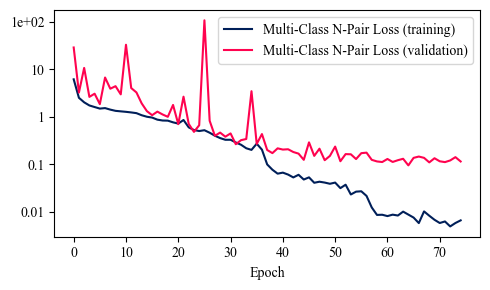

In [16]:
from core.viz import visualize_history

visualize_history(
    best_model_history,
    ["loss"],
    "Multi-Class N-Pair Loss",
    f"{FIG_DIR}/npair_loss_history.svg",
    log_yscale=True
)

Let's see if our model performs well despite those loss spikes.

A naive way of evaluating the model's One-Shot classification accuracy would be to use the same batch generation method for the test set:

In [17]:
test_gen = NPairDataGen(x_test, y_test)

In [18]:
loss = siamese_snn.evaluate(test_gen, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.8545


In [19]:
from keras.models import Model

def npair_predict(model: Model, test_gen: NPairDataGen):
    """Run prediction on NPair Generator and format as integer (y_true, y_pred)."""
    preds = model.predict(test_gen)
    preds = preds.reshape((-1, 2, 5, model.output.shape[-1]))

    Y_pred: list[int] = []
    Y_true: list[int] = []

    for i, pred in enumerate(preds):
        e_anchor = pred[0]
        e_positive = pred[1]
        y_pred = np.matmul(e_anchor, e_positive.T)
        _, y_true = test_gen[i]
        y_true = np.expand_dims(y_true, axis=-1)
        y_true = np.equal(y_true, y_true.T).astype(y_pred.dtype)

        y_true = np.argmax(y_true, axis=-1)
        y_pred = np.argmax(y_pred, axis=-1)
        
        Y_pred.extend(list(y_pred))
        Y_true.extend(list(y_true))
    
    return (Y_true, Y_pred)

In [20]:
y_true, y_pred = npair_predict(siamese_snn, test_gen)

305/305 [==============================] - 1s 3ms/step


Doing so would result in a very even distribution of classification errors, which seems like a great success:

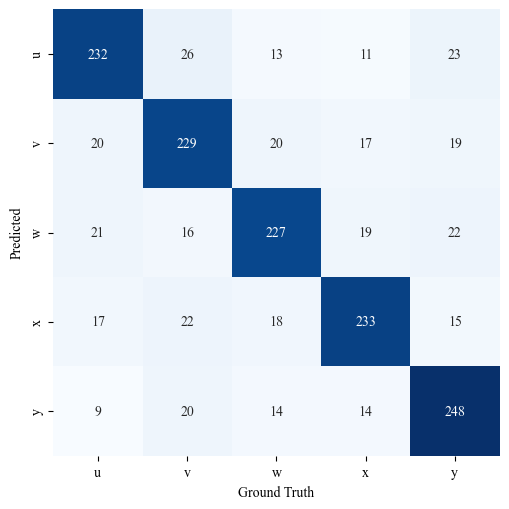

In [21]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/npair_loss_conf_matrix_naive.svg"
)

However, we have to remember, that the custom batch construction method feeds only positive pairs into the model.

For actual predictions this is impossible to do: if we knew which samples were similar and wich dissimilar we would not need a classifier.

Therefore, we'll once again separate the encoder part of the model and evaluate it the same way we evaluated the Contrastive and Triplet Loss models:

In [22]:
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)

x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

The Multi-Class N-Pair Loss models One-Shot 5-way accuracy remains lower than the accuracy achieved using Contrastive Loss:

In [23]:
from core.util import evaluate_n_way_accuracy


y_true, y_pred, mean_acc, min_acc, max_acc, std = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=1,
    iterations=10
)

print(
    f"Mean 5-way accuracy: {mean_acc}\n"
    f"Min 5-way accuracy: {min_acc}\n"
    f"Max 5-way accuracy: {max_acc}\n"
    f"5-way accuracy std.: {std}"
)

Mean 5-way accuracy: 0.6881012658227849
Min 5-way accuracy: 0.5164556962025316
Max 5-way accuracy: 0.8107594936708861
5-way accuracy std.: 0.09170787797256248


The model also struggles with the discrimination of "u" and "v" classes in much the same way:

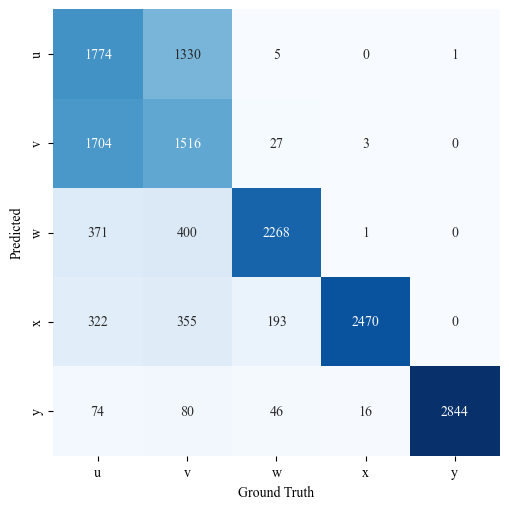

In [24]:
unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/npair_loss_conf_matrix.svg"
)

Using support prototypes drastically improves the model's performance, but it still lacks behind Contrastive Loss:

In [25]:
from core.util import save_n_way_k_prototype_accuracy

save_n_way_k_prototype_accuracy(
    x_test,
    y_test,
    snn_encoder,
    METRICS_FILEPATH,
    "Multi-Class N-Pair Loss"
)

Mean 5-way accuracy (k-prototype = 1): 0.6881012658227849, std: 0.09170787797256248
Mean 5-way accuracy (k-prototype = 3): 0.7623566878980893, std: 0.04683105588220703
Mean 5-way accuracy (k-prototype = 5): 0.7905769230769232, std: 0.03675939726533856
Mean 5-way accuracy (k-prototype = 10): 0.8099674267100976, std: 0.02482255673062977
Mean 5-way accuracy (k-prototype = 15): 0.8010596026490064, std: 0.020043809743198374
Mean 5-way accuracy (k-prototype = 20): 0.8119191919191919, std: 0.01721339103665997
Mean 5-way accuracy (k-prototype = 50): 0.809812734082397, std: 0.009659436702926037
Mean 5-way accuracy (k-prototype = 75): 0.8126446280991736, std: 0.013098847663907667
Mean 5-way accuracy (k-prototype = 100): 0.812995391705069, std: 0.009412209722487828
Saved Multi-Class N-Pair Loss metrics to metrics.json


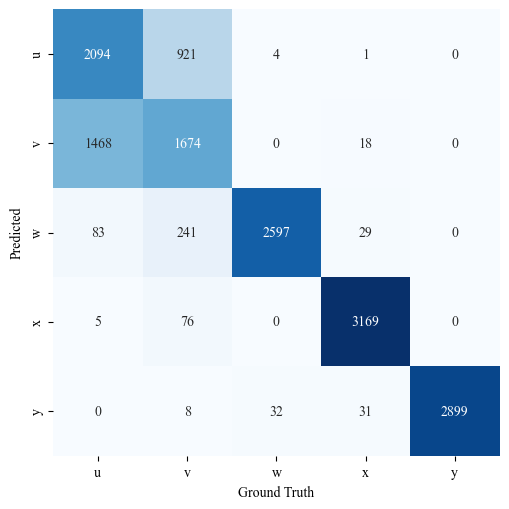

In [26]:
y_true, y_pred, _, _, _, _ = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=10,
    iterations=10
)

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/npair_loss_conf_matrix_k10.svg"
)

Lastly, we'll visualize this model's embedding space:

In [27]:
# And get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

50/50 [==============================] - 0s 4ms/step


In [28]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1585 samples in 0.000s...
[t-SNE] Computed neighbors for 1585 samples in 0.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1585
[t-SNE] Computed conditional probabilities for sample 1585 / 1585
[t-SNE] Mean sigma: 3.048883
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.875130
[t-SNE] KL divergence after 1000 iterations: 0.413897


Unsurprisingly, the embeddings do look better separated than with Triplet Loss, but we can still observe the overlap of "u" and "v" samples:

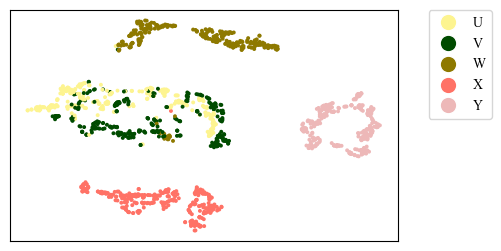

In [29]:
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
visualize_embeddings(
    reduced_embeddings,
    y_test,
    label_map,
    f"{FIG_DIR}/npair_loss_embeddings.svg"
)

Although we weren't able to improve upon the Contrastive Loss model, the results are still very interesting.

As a [conclusion to the experiments](./prototype_comparison.ipynb), we'll compare how the different models benefit from different amounts of samples being used to form the support prototypes.